Referencing a deep learning model from the article below:
https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

In [161]:
# pip install tensorflow

In [162]:
# Load Modules
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import accuracy_score

In [163]:
# Set Plotting Styles
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (18, 18)

In [164]:
# Load Data
# comed_df = pd.read_csv('Resources/DataFiles/COMED_hourly.csv', index_col=[0], parse_dates=[0])
comed_df = pd.read_csv('Resources/DataFiles/COMED_hourly.csv')

# Formating to datetime
comed_df['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in comed_df['Datetime']]

# Sort Data
comed_df.sort_index(inplace=True)

comed_df.head

<bound method NDFrame.head of                  Datetime  COMED_MW
0     2011-12-31 01:00:00    9970.0
1     2011-12-31 02:00:00    9428.0
2     2011-12-31 03:00:00    9059.0
3     2011-12-31 04:00:00    8817.0
4     2011-12-31 05:00:00    8743.0
...                   ...       ...
66492 2018-01-01 20:00:00   13858.0
66493 2018-01-01 21:00:00   13758.0
66494 2018-01-01 22:00:00   13627.0
66495 2018-01-01 23:00:00   13336.0
66496 2018-01-02 00:00:00   12816.0

[66497 rows x 2 columns]>

In [165]:
# Identify Duplicate Indices
duplicate_index = comed_df[comed_df.index.duplicated()]

comed_df.loc[duplicate_index.index.values, :]

,Datetime,COMED_MW


In [166]:
# Replace Duplicates with Mean Value
comed_df = comed_df.groupby('Datetime').agg(np.mean)

# Set DatetimeIndex Frequency
comed_df = comed_df.asfreq('H')

# print(comed_df)

In [167]:
# Determine # of Missing Values
print('# of Missing COMED_MW Values: {}'.format(len(comed_df[comed_df['COMED_MW'].isna()])))

# of Missing COMED_MW Values: 11


In [168]:
# Impute Missing Values
comed_df['COMED_MW'] = comed_df['COMED_MW'].interpolate(limit_area='inside', limit=None)

In [169]:
comed_df.head()

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0


In [170]:
# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [171]:

# def create_X_Y(ts: list, lag: int) -> tuple:
#     """
#     A method to create X and Y matrix from a time series list for the training of 
#     deep learning models 
#     """
#     X, Y = [], []

#     if len(ts) - lag <= 0:
#         X.append(ts)
#     else:
#         for i in range(len(ts) - lag):
#             Y.append(ts[i + lag])
#             X.append(ts[i:(i + lag)])

#     X, Y = np.array(X), np.array(Y)

#     # Reshaping the X array to an LSTM input shape 
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#     return X, Y

In [172]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat   

In [173]:
# Initiating the class
deep_learner = DeepModelTS(
data = comed_df,
Y_var = 'COMED_MW',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [174]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
221/221 [==============================] - 7s 16ms/step - loss: 2843599.2500 - val_loss: 496986.6250
Epoch 2/10
221/221 [==============================] - 3s 14ms/step - loss: 570715.3750 - val_loss: 723755.6250
Epoch 3/10
221/221 [==============================] - 3s 14ms/step - loss: 563405.1250 - val_loss: 405833.7188
Epoch 4/10
221/221 [==============================] - 3s 15ms/step - loss: 526914.9375 - val_loss: 438095.4688
Epoch 5/10
221/221 [==============================] - 3s 14ms/step - loss: 461823.8125 - val_loss: 472490.1875
Epoch 6/10
221/221 [==============================] - 3s 15ms/step - loss: 420951.0625 - val_loss: 429536.3438
Epoch 7/10
221/221 [==============================] - 3s 14ms/step - loss: 384889.9062 - val_loss: 357008.2812
Epoch 8/10
221/221 [==============================] - 3s 12ms/step - loss: 553766.6250 - val_loss: 320357.2500
Epoch 9/10
221/221 [==============================] - 3s 12ms/step - loss: 1427692.8750 - val_loss: 1800291.625

In [175]:
deep_learner = DeepModelTS(
data = comed_df,
Y_var = 'COMED_MW',
lag = 24, # 24 past hours are used
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)
model = deep_learner.LSTModel()

Epoch 1/10
221/221 [==============================] - 14s 45ms/step - loss: 20166102.0000 - val_loss: 1227948.8750
Epoch 2/10
221/221 [==============================] - 10s 44ms/step - loss: 1739802.0000 - val_loss: 2447346.2500
Epoch 3/10
221/221 [==============================] - 9s 42ms/step - loss: 3333227.2500 - val_loss: 2855966.0000
Epoch 4/10
221/221 [==============================] - 9s 41ms/step - loss: 2838450.0000 - val_loss: 2818741.7500
Epoch 5/10
221/221 [==============================] - 10s 46ms/step - loss: 3134481.2500 - val_loss: 3046974.0000
Epoch 6/10
221/221 [==============================] - 9s 42ms/step - loss: 1837635.0000 - val_loss: 1312721.8750
Epoch 7/10
221/221 [==============================] - 11s 48ms/step - loss: 2281654.0000 - val_loss: 3780365.2500
Epoch 8/10
221/221 [==============================] - 10s 47ms/step - loss: 2856312.2500 - val_loss: 3023918.0000
Epoch 9/10
221/221 [==============================] - 11s 50ms/step - loss: 2651289.2500 -

In [176]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = comed_df['COMED_MW'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

1/1 [==============================] - 1s 730ms/step


312/312 [==============================] - 3s 10ms/step


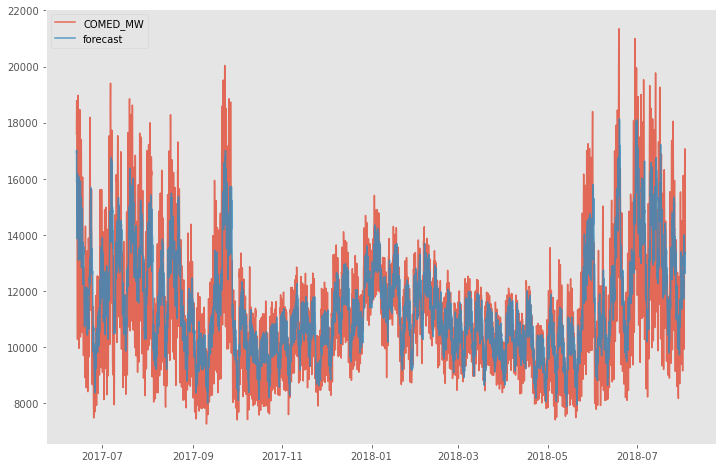

In [177]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = comed_df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['COMED_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [178]:
# Creating the model using full data and forecasting n steps 
aheaddeep_learner = DeepModelTS(
    data = comed_df,
    Y_var = 'COMED_MW',
    lag = 48,
    LSTM_layer_depth = 75,
    epochs = 10,
    train_test_split = 0.1
)

In [179]:
# Fitting the model
deep_learner.LSTModel()

Epoch 1/10
221/221 [==============================] - 27s 93ms/step - loss: 38808964.0000 - val_loss: 8028459.0000
Epoch 2/10
221/221 [==============================] - 12s 54ms/step - loss: 7866616.0000 - val_loss: 10197501.0000
Epoch 3/10
221/221 [==============================] - 13s 60ms/step - loss: 10228420.0000 - val_loss: 7364716.5000
Epoch 4/10
221/221 [==============================] - 13s 59ms/step - loss: 8547431.0000 - val_loss: 4416415.0000
Epoch 5/10
221/221 [==============================] - 12s 54ms/step - loss: 3139660.5000 - val_loss: 3073296.0000
Epoch 6/10
221/221 [==============================] - 11s 48ms/step - loss: 2834447.7500 - val_loss: 2762019.5000
Epoch 7/10
221/221 [==============================] - 10s 45ms/step - loss: 2677639.5000 - val_loss: 3439063.2500
Epoch 8/10
221/221 [==============================] - 10s 45ms/step - loss: 3739944.2500 - val_loss: 2097347.7500
Epoch 9/10
221/221 [==============================] - 10s 46ms/step - loss: 1824268.3

In [180]:
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

1/1 [==============================] - 0s 26ms/step


In [181]:
# Constructing the forecast dataframe
fc = comed_df.tail(400).copy() 
fc['type'] = 'original'
fc = fc.reset_index()

last_date = max(fc['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(hours = x + 1) for x in range(n_ahead)], 
    'COMED_MW': yhat,
    'type': 'forecast'
})


In [182]:
fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

fc.head

C:\Users\plymb\AppData\Local\Temp\ipykernel_18888\2612100435.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


<bound method NDFrame.head of                Datetime      COMED_MW      type
0   2018-07-17 09:00:00  12802.000000  original
1   2018-07-17 10:00:00  13830.000000  original
2   2018-07-17 11:00:00  14677.000000  original
3   2018-07-17 12:00:00  15477.000000  original
4   2018-07-17 13:00:00  16073.000000  original
..                  ...           ...       ...
563 2018-08-09 20:00:00  11188.761719  forecast
564 2018-08-09 21:00:00  11143.978516  forecast
565 2018-08-09 22:00:00  11212.885742  forecast
566 2018-08-09 23:00:00  11192.828125  forecast
567 2018-08-10 00:00:00  11211.714844  forecast

[568 rows x 3 columns]>

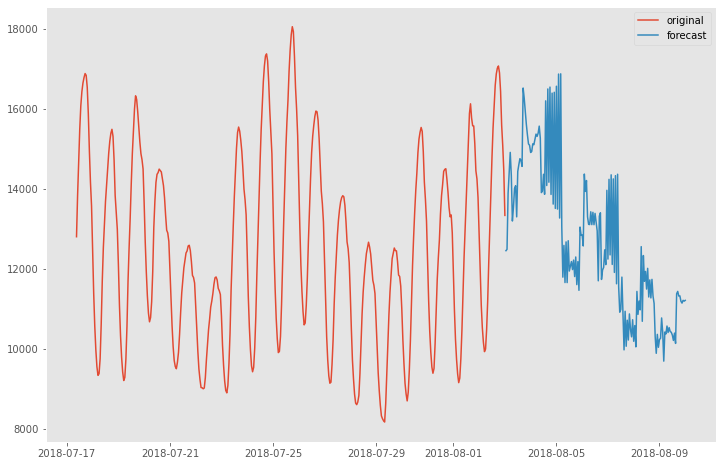

In [183]:
# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'Datetime', 
        'COMED_MW', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()
plt.show()  